## DS IC/A1 data averaged across passives and actives
#### DS December 2018


Batches:
* **d_AC_307** DS, SU and MU, onBF and offBF
* **d_IC_309** DS, SU and MU, onBF and offBF

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as sci
import statsmodels.formula.api as smf
import matplotlib.collections as clt
import re
import pylab as pl

from nems_lbhb.pupil_behavior_scripts.mod_per_state import get_model_results_per_state_model
from nems_lbhb.pupil_behavior_scripts.mod_per_state import aud_vs_state
from nems_lbhb.pupil_behavior_scripts.mod_per_state import hlf_analysis
from nems_lbhb.stateplots import model_per_time_wrapper, beta_comp

%matplotlib inline
os.getcwd()

color_b = '#82418B' #dark purple 
color_p = '#2E7E3E' #dark green

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 60)

[nems.configs.defaults INFO] Saving log messages to /tmp/nems/NEMS 2019-01-06 172301.log
[nems_web INFO] Found setting: DEBUG in nems_web.configs.settings, setting value in environment ... 
[nems_web INFO] Found setting: CSRF_ENABLED in nems_web.configs.settings, setting value in environment ... 
[nems_web INFO] Found setting: CSRF_SESSION_KEY in nems_web.configs.settings, setting value in environment ... 
[nems_web INFO] Found setting: SECRET_KEY in nems_web.configs.settings, setting value in environment ... 
[nems_web INFO] No value specified for: PORT. Using default value in nems_web.configs.defaults


Load 307 (A1) and 309 (IC) dataframes

In [2]:
# RUN IF CONNECTED TO SERVER

# A1 SUA+MUA: pup vs. beh 307 per state dataframe
#batch = 307  # A1 SUA and MUA
#state_list = ['st.pup0.beh0','st.pup0.beh','st.pup.beh0','st.pup.beh']
#basemodel = "-ref-psthfr.s_sdexp.S"
#d_pb307 = get_model_results_per_state_model(batch=batch, state_list=state_list, basemodel=basemodel)

In [3]:
# RUN IF NOT CONNECTED TO SERVER 
# A1 SUA+MUA: pup vs. beh 307 per state 
d_pb307 = pd.read_csv('d_307_pb.csv') #model rerun November 8 sdexp.S

In [4]:
d_pb307 = d_pb307.drop(['Unnamed: 0'], axis=1)

# Add extra metadata columns 
d_pb307['R2'] = d_pb307['r']**2 * np.sign(d_pb307['r'])
d_pb307['area'] = 'A1'
d_pb307['experimenter'] = 'DS'
d_pb307['onBF'] = 'TBD'
d_pb307['SU'] = False
d_pb307.loc[d_pb307['isolation']>=90.0, 'SU'] = True
d_pb307['animal'] = d_pb307['cellid'].map(lambda x: x[:3])
d_pb307['task'] = 'TIN'

In [5]:
## RUN IF CONNECTED TO SERVER

# IC SUA+MUA: pup vs. beh 307 per state dataframe
#batch = 309  # IC SUA and MUA
#state_list = ['st.pup0.beh0','st.pup0.beh','st.pup.beh0','st.pup.beh']
#basemodel = "-ref-psthfr.s_stategain.S"
#d_pb309 = get_model_results_per_state_model(batch=batch, state_list=state_list, basemodel=basemodel)

In [6]:
# RUN IF NOT CONNECTED TO SERVER 
# IC SUA+MUA: pup vs. beh 309 per state dataframe
d_pb309 = pd.read_csv('d_309_pb.csv')

In [7]:
d_pb309 = d_pb309.drop(['Unnamed: 0'], axis=1)

# Add extra metadata columns 
d_pb309['R2'] = d_pb309['r']**2 * np.sign(d_pb309['r'])
d_pb309['onBF'] = 'TBD'
d_pb309['experimenter'] = 'DS'
d_pb309['area'] = 'IC'
d_pb309['animal'] = d_pb309['cellid'].map(lambda x: x[:3])
d_pb309['task'] = 'TIN'
d_pb309.loc[d_pb309['animal']=='ley', 'task'] = 'TvN'
d_pb309['SU'] = False
d_pb309.loc[d_pb309['isolation']>=90.0, 'SU'] = True

Load 307 and 309 strf dataframes

In [8]:
# generated by running get_ptd_tuning in MATLAB and then running struct2csv(cellframe, 'tuning_info_batch_307.csv')
d_307_strf = pd.read_csv('tuning_info_batch_307.csv')
d_307_strf = d_307_strf.drop(['Unnamed: 43'], axis=1)

In [9]:
# generated by running get_ptd_tuning in MATLAB and then running struct2csv(cellframe, 'tuning_info_batch_307.csv')
d_309_strf = pd.read_csv('tuning_info_batch_309.csv')
d_309_strf = d_309_strf.drop(['Unnamed: 43'], axis=1)

Concatenate 307 and 309 data dataframes

In [10]:
d_307_309 = pd.concat([d_pb307, d_pb309], sort=False)

Concatenate 307 and 309 strf dataframes

In [11]:
d_307_309_strf = pd.concat([d_307_strf, d_309_strf], sort=False)

Merge it all

In [12]:
df = pd.merge(left=d_307_309, right=d_307_309_strf, how='outer', on='cellid')

In [13]:
def fix_TBD_onBF(df):
    '''This function takes the monster dataframe and adds True to the column 'onBF' when 'ACTIVE_1_tardist' is
    within 0.5 --> half an octave between unit BF and target frequency in ACTIVE 1'''
    BF_TBD = (df['onBF']=='TBD')
    df.loc[BF_TBD, 'onBF'] = df.loc[BF_TBD, 'ACTIVE_1_tardist'].map(lambda x: abs(x)<=0.5)
    return df

In [14]:
df['onBF'].value_counts()

TBD    2340
Name: onBF, dtype: int64

In [15]:
df = fix_TBD_onBF(df)

In [16]:
df['onBF'].value_counts()

False    1428
True      912
Name: onBF, dtype: int64

In [17]:
df.head()

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,R2,area,experimenter,onBF,SU,animal,task,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,PASSIVE_1_bf,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4
0,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,baseline,NaN,95.4293,0.452884,0.025611,0.026288,1.022688,baseline,0.205103,A1,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,816.0,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,pupil,0.010855,95.4293,0.452884,0.025611,0.013340,0.027984,pupil,0.205103,A1,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,816.0,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,active,-0.000702,95.4293,0.452884,0.025611,0.031175,0.021035,active,0.205103,A1,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,816.0,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,baseline,NaN,95.4293,0.452708,0.025073,0.047462,0.996078,baseline,0.204945,A1,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,816.0,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,BRT039c-40-1,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,pupil,0.013942,95.4293,0.452708,0.025073,0.014610,0.060707,pupil,0.204945,A1,DS,False,True,BRT,TIN,0.97222,816,0.46839,735,BRT039c05_p_PTD.m,0.56382,816.0,BRT039c06_a_PTD.m,5000.0,-2.6153,0.97222,816.0,BRT039c07_p_PTD.m,0.64228,3809.0,BRT039c08_a_PTD.m,5000.0,-2.6153,NaN,NaN,NaN,NaN,NaN,0.50432,1480.0,BRT039c04_a_PTD.m,5000.0,-2.6153,0.63875,3809.0,BRT039c09_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Example cells TAR010c-27-2 (A1 behavior cell)
df.loc[df['cellid']=='TAR010c-27-2']

,cellid,modelname,state_sig,state_chan,MI,isolation,r,r_se,d,g,state_chan_alt,R2,area,experimenter,onBF,SU,animal,task,bestsnr,bestbf,PASSIVE_0_snr,PASSIVE_0_bf,PASSIVE_0,ACTIVE_1_snr,ACTIVE_1_bf,ACTIVE_1,ACTIVE_1_tf,ACTIVE_1_tardist,PASSIVE_1_snr,PASSIVE_1_bf,PASSIVE_1,ACTIVE_2_snr,ACTIVE_2_bf,ACTIVE_2,ACTIVE_2_tf,ACTIVE_2_tardist,ACTIVE_3_snr,ACTIVE_3_bf,ACTIVE_3,ACTIVE_3_tf,ACTIVE_3_tardist,ACTIVE_0_snr,ACTIVE_0_bf,ACTIVE_0,ACTIVE_0_tf,ACTIVE_0_tardist,PASSIVE_2_snr,PASSIVE_2_bf,PASSIVE_2,PASSIVE_3_snr,PASSIVE_3_bf,PASSIVE_3,ACTIVE_4_snr,ACTIVE_4_bf,ACTIVE_4,ACTIVE_4_tf,ACTIVE_4_tardist,PASSIVE_4_snr,PASSIVE_4_bf,PASSIVE_4
420,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,baseline,NaN,95.0,0.408684,0.020415,-0.009625,1.018744,baseline,0.167023,A1,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,1449.0,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,pupil,0.000654,95.0,0.408684,0.020415,-0.061233,0.060229,pupil,0.167023,A1,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,1449.0,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
422,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh0-ref-psthfr.s_sde...,st.pup0.beh0,active,0.000077,95.0,0.408684,0.020415,-0.089852,0.345671,active,0.167023,A1,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,1449.0,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
423,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,baseline,NaN,95.0,0.547967,0.024350,1.410993,0.051466,baseline,0.300268,A1,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,1449.0,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
424,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,pupil,0.170756,95.0,0.547967,0.024350,-0.019316,0.019379,pupil,0.300268,A1,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,1449.0,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
425,TAR010c-27-2,psth.fs20.pup-ld-st.pup0.beh-ref-psthfr.s_sdex...,st.pup0.beh,active,0.365985,95.0,0.547967,0.024350,2.217914,3.225629,active,0.300268,A1,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,1449.0,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
426,TAR010c-27-2,psth.fs20.pup-ld-st.pup.beh0-ref-psthfr.s_sdex...,st.pup.beh0,baseline,NaN,95.0,0.469955,0.022545,3.175568,3.350028,baseline,0.220858,A1,DS,True,True,TAR,TIN,0.087307,490,-0.020426,457,TAR010c04_p_PTD.m,0.087307,490.0,TAR010c09_a_PTD.m,500.0,-0.029146,0.02751,1449.0,TAR010c10_p_PTD.m,0.027281,154.0,TAR010c11_a_PTD.m,500.0,-0.029146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.002538,671.0,TAR010c12_p_PTD.m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
427,TAR010c-27-2,psth.fs20.pup-ld-st.pup.beh0-ref-psthfr.s_sdex...,st.pup.be

Add new columns to df  
`R2_diff = R2_full - R2_null`  
`MIbeh_only = MI_pup0beh-MI_pup0beh0`  
`MIbeh_unique = MI_pupbeh-MIpupbeh0`

In [19]:
# creating list of booleans to mask A1, IC, onBF and offBF out of big df
A1 = df['area']=='A1'
IC = df['area']=='IC'
onBF = df['onBF']==True
offBF = df['onBF']==False

# creating subdf with only rows that match conditions
is_active = (df['state_chan']=='active')
full_model = (df['state_sig']=='st.pup.beh')
null_model = (df['state_sig']=='st.pup0.beh0')
part_beh_model = (df['state_sig']=='st.pup0.beh')
part_pup_model = (df['state_sig']=='st.pup.beh0')

# adding new colums to df with differences of R2 full-null, MI full-partial pup, and MI partial beh-null
for cellid in df['cellid'].unique():
    mask_for_cellid = df['cellid']==cellid
    active_full = df[is_active & full_model & mask_for_cellid]
    active_null = df[is_active & null_model & mask_for_cellid]
    active_part_beh = df[is_active & part_beh_model & mask_for_cellid]
    active_part_pup = df[is_active & part_pup_model & mask_for_cellid]
    if len(active_full) != 1:
        print(f'WARNING: active full is not one for {cellid}')
        continue
    if len(active_null) != 1:
        print(f'WARNING: active null is not one for {cellid}')
        continue
    df.loc[mask_for_cellid, 'R2_diff'] = active_full.iloc[0]['R2']-active_null.iloc[0]['R2']
    df.loc[mask_for_cellid, 'MIbeh_only'] = active_part_beh.iloc[0]['MI']-active_null.iloc[0]['MI']
    df.loc[mask_for_cellid, 'MIbeh_unique'] = active_full.iloc[0]['MI']-active_part_pup.iloc[0]['MI']

/home/svd/bin/miniconda3/envs/nems2/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


Text(0.5,1,'A1')

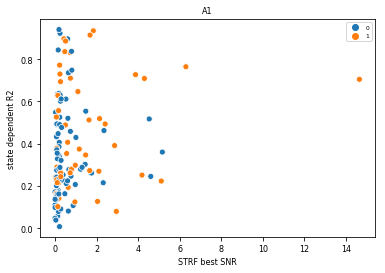

In [23]:
# plot for A1 separating for onBF - full model 
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df.loc[full_model & is_active & A1,'onBF'].as_matrix().astype(int), data=df[full_model & is_active & A1])
plt.ylabel('state dependent R2')
plt.xlabel('STRF best SNR')
plt.title('A1')
#plt.xlim(0,15)

In [24]:
# quantify correlation between R2 and snr for A1
(cc_A1_full, p_value_A1_full) = sci.stats.pearsonr(df.loc[full_model & is_active & A1, 'bestsnr'], 
                                                   df.loc[full_model & is_active & A1, 'R2'])
print(cc_A1_full, p_value_A1_full)

0.17092692299149456 0.052777337468825826


In [25]:
# plot for IC separating for onBF - full model 
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[full_model & is_active & IC])
plt.ylabel('state dependent R2')
plt.xlabel('STRF best SNR')
plt.title('IC')

/home/svd/bin/miniconda3/envs/nems2/lib/python3.6/site-packages/pandas/core/generic.py:2474: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return self[key]


ValueError: could not broadcast input array from shape (66) into shape (63)

In [ ]:
# quantify correlation between R2 and snr for IC - full model
(cc_IC_full, p_value_IC_full) = sci.stats.pearsonr(df.loc[full_model & is_active & IC, 'bestsnr'], 
                                                   df.loc[full_model & is_active & IC, 'R2'])
print(cc_IC_full, p_value_IC_full)

In [ ]:
# plot for A1 separating for onBF - null model
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[null_model & is_active & A1])
plt.ylabel('state independent R2')
plt.xlabel('STRF best SNR')
plt.title('A1')
#plt.xlim(0,15)

In [ ]:
# quantify correlation between R2 and snr for A1 - full model
(cc_A1_null, p_value_A1_null) = sci.stats.pearsonr(df.loc[null_model & is_active & A1, 'bestsnr'], 
                                                   df.loc[null_model & is_active & A1, 'R2'])
print(cc_A1_null, p_value_A1_null)

In [ ]:
# plot for IC separating for onBF - null model 
ax = sns.scatterplot(x='bestsnr', y='R2', hue=df['onBF'], data=df[null_model & is_active & IC])
plt.ylabel('state independent R2')
plt.xlabel('STRF best SNR')
plt.title('IC')

In [ ]:
# quantify correlation between R2 and snr for IC - null model
(cc_IC_null, p_value_IC_null) = sci.stats.pearsonr(df.loc[null_model & is_active & IC, 'bestsnr'], 
                                                   df.loc[null_model & is_active & IC, 'R2'])
print(cc_IC_null, p_value_IC_null)

Plot R2_diff versus SNR (sqrt)

In [ ]:
# plot snr vs R2 diff for A1
ax = sns.scatterplot(x=np.sqrt(df.loc[full_model & is_active & A1, 'bestsnr']), 
                     y=df.loc[full_model & is_active & A1, 'R2_diff'],
                     hue=df.loc[full_model & is_active & A1, 'onBF'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('STRF best SNR')
plt.title('A1')

In [ ]:
# plot snr vs R2 diff for IC
ax = sns.scatterplot(x=np.sqrt(df.loc[full_model & is_active & IC, 'bestsnr']), 
                     y=df.loc[full_model & is_active & IC, 'R2_diff'],
                     hue=df.loc[full_model & is_active & IC, 'onBF'])
plt.ylabel('state dependent - statet independent R2')
plt.xlabel('STRF best SNR')
plt.title('IC')

In [ ]:
# sort based on MI
df_MI_unique_sorted = df.sort_values('MIbeh_unique')
df_MI_only_sorted = df.sort_values('MIbeh_only')

In [ ]:
# note that it does not matter if choose full_model, null_model, part_beh_model, part_pup_model as they all have same length 
x_axis_A1 = list(range(len(df[full_model & is_active & A1])))
x_axis_IC = list(range(len(df[full_model & is_active & IC])))

In [ ]:
print(len(x_axis_A1))
print(len(x_axis_IC))

In [ ]:
plt.figure()
plt.bar(x_axis_A1, df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'], color = color_b, edgecolor = color_b) 
plt.ylim((-0.7,0.5))
plt.xlabel('A1 units')
plt.ylabel('MI_task only (pupil ignored)')
plt.title('MI_task only (A1)')
plt.savefig('MI_task_only_A1.pdf')

In [ ]:
plt.figure()
plt.bar(x_axis_A1, df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'], color = color_b, 
        edgecolor = color_p, linewidth=0.5) 
plt.ylim((-0.7,0.5))
plt.xlabel('A1 units')
plt.ylabel('MI_task unique (pupil regressed out)')
plt.title('MI_task unique (A1)')
plt.savefig('MI_task_unique_A1.pdf')

In [ ]:
print(df.loc[full_model & is_active & A1, 'MIbeh_unique'].median())
print(df.loc[full_model & is_active & A1, 'MIbeh_only'].median())

In [ ]:
plt.figure()
plt.bar(x_axis_IC, df_MI_only_sorted.loc[full_model & is_active & IC, 'MIbeh_only'], color = color_b, edgecolor = color_b) 
plt.ylim((-0.4,0.6))
plt.xlabel('IC units')
plt.ylabel('MI_task only (pupil ignored)')
plt.title('MI_task only (IC)')
plt.savefig('MI_task_only_IC.pdf')

In [ ]:
plt.figure()
plt.bar(x_axis_IC, df_MI_unique_sorted.loc[full_model & is_active & IC, 'MIbeh_unique'], color = color_b, 
        edgecolor = color_p, linewidth=0.5) 
plt.ylim((-0.4,0.6))
plt.xlabel('IC units')
plt.ylabel('MI_task unique (pupil regressed out)')
plt.title('MI_task unique (IC)')
plt.savefig('MI_task_unique_IC.pdf')

In [ ]:
# Cumulative distributions of MIbeh only and MIbeh unique for A1
values_u, base_u = np.histogram(df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'], bins=1000)
cumulative_u = np.cumsum(values_u)
values_o, base_o = np.histogram(df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'], bins=1000)
cumulative_o = np.cumsum(values_o)
plt.plot(base_u[:-1], cumulative_u, c=color_p)
plt.plot(base_o[:-1], cumulative_o, c=color_b)
plt.savefig('cum_MIu_MIo_A1.pdf')

In [ ]:
# Two-sample Kolmogorov-Smirnov A1
sci.ks_2samp(df_MI_unique_sorted.loc[full_model & is_active & A1, 'MIbeh_unique'], 
             df_MI_only_sorted.loc[full_model & is_active & A1, 'MIbeh_only'])                                                                 

In [ ]:
# Cumulative distributions of MIbeh only and MIbeh unique for IC
values_u, base_u = np.histogram(df_MI_unique_sorted.loc[full_model & is_active & IC, 'MIbeh_unique'], bins=1000)
cumulative_u = np.cumsum(values_u)
values_o, base_o = np.histogram(df_MI_only_sorted.loc[full_model & is_active & IC, 'MIbeh_only'], bins=1000)
cumulative_o = np.cumsum(values_o)
plt.plot(base_u[:-1], cumulative_u, c=color_p)
plt.plot(base_o[:-1], cumulative_o, c=color_b)  
plt.savefig('cum_MIu_MIo_IC.pdf')

In [ ]:
# Two-sample Kolmogorov-Smirnov IC
sci.ks_2samp(df_MI_unique_sorted.loc[full_model & is_active & IC, 'MIbeh_unique'], 
             df_MI_only_sorted.loc[full_model & is_active & IC, 'MIbeh_only'])
                                                                                       